<a href="https://colab.research.google.com/github/phps-28/Data-Science-PGEBM/blob/master/Mestrado/Projeto/Teste_2_Classifica%C3%A7%C3%A3o_de_Imagens_de_Embri%C3%B5es.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Utilizando transferência de aprendizado com a rede de convolução já treinada (ResNet50)

## **Importando as Libs**

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers

## Subindo o arquivo zipado com as imagens

In [2]:
!unzip -q Base.zip
!ls

Base  Base.zip	sample_data


Agora temos uma pasta '100' que contém 7 subpastas. Cada subpasta contem arquivos de imagem de cada categoria.

In [3]:
!ls Base

AA  CB


In [4]:
import os	#"AB", "BA", "BB", "BC", "CA",

# Testes com todas as categorias
num_skipped = 0
for folder_name in ("AA", "CB"): # descrevendo as pastas presentes dentro do arquivo main "Base"
    folder_path = os.path.join("Base", folder_name) # juntando o caminho de cada uma das pastas com o caminho da main pasta(Base)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname) # estabelecendo o caminho completo de cada imagem dentro da pasta main e subpastas
        try:
            fobj = open(fpath, "rb") # lendo e abrindo cada uma das imagens
            is_pfif = tf.compat.as_bytes("PFIF") in fobj.peek(10) # verificando a extensão correta das imagens '.png'
        finally:
            fobj.close()

print("Deletadas %d imagens" % num_skipped)

Deletadas 0 imagens


## Visualizando as Imagens

In [5]:
sample_image = tf.keras.preprocessing.image.load_img(r'/content/Base/AA/3AA.1.PNG', target_size = (224, 224))

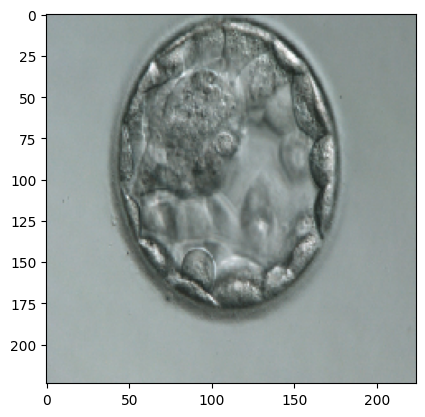

In [6]:
plt.imshow(sample_image);

In [7]:
type(sample_image)

PIL.Image.Image

In [8]:
sample_image = tf.keras.preprocessing.image.img_to_array(sample_image)

In [9]:
type(sample_image)

numpy.ndarray

In [10]:
np.shape(sample_image)

(224, 224, 3)

In [11]:
sample_image = np.expand_dims(sample_image, axis = 0)

In [12]:
sample_image.shape

(1, 224, 224, 3)

In [13]:
sample_image.max() # + próximo de branco

254.0

In [14]:
sample_image.min() # + próximo de preto

30.0

Fazendo a normalização dos pixels da imagem usando o pre processamento da ResNet50

In [15]:
sample_image = tf.keras.applications.resnet50.preprocess_input(sample_image)

In [16]:
sample_image.max() # + próximo de branco

150.061

In [17]:
sample_image.min() # + próximo de preto

-93.68

## Fazer a Tranferência de Aprendizado e Reuso do Modelo

In [18]:
base_model =  tf.keras.applications.ResNet50(weights = 'imagenet', include_top = False)

94765736/94765736 [==============================] - 3s 0us/step


In [ ]:
base_model.summary()

Agora será criada a rede neural Densa, que será personalizada, para juntá-la com essas camadas de convolução e pooling da ResNet 50

In [20]:
x = base_model.output

In [21]:
# Será feito a diminuição da dimensão desta última camada de saída da rede ResNet50 fazedno um pooling com a média dos valores da matriz dos pixels
x = tf.keras.layers.GlobalAveragePooling2D()(x)

In [22]:
# Criando as camadas Densas personalizadas
x = tf.keras.layers.Dense(1024, activation='relu')(x)
x = tf.keras.layers.Dense(1024, activation='relu')(x)
x = tf.keras.layers.Dense(1024, activation='relu')(x)
x = tf.keras.layers.Dense(512, activation='relu')(x)
preds = tf.keras.layers.Dense(2, activation='softmax')(x)

In [23]:
# Criando um modelo que seja a união do modelo pré treinado + as camadas densas personalizadas
model = tf.keras.models.Model(inputs = base_model.input, outputs = preds)

In [ ]:
model.summary()

In [ ]:
for i, layer in enumerate(model.layers):
  print(i, layer.name)

In [26]:
# Como as camadas até a 175 são do modelo que já foi treinado, até a 175 não precisa ser treinada novamente
for layer in model.layers[:175]:
  layer.trainable = False

In [27]:
# serão treinadas as cmadas da 175 em diante, que são as camadas densas personalizadas
for layer in model.layers[175:]:
  layer.trainable = True

In [28]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function=tf.keras.applications.resnet50.preprocess_input)

In [29]:
train_generator = train_datagen.flow_from_directory('/content/Base',
                                                    target_size = (224,224),
                                                    color_mode = 'rgb',
                                                    batch_size = 10,
                                                    class_mode = 'categorical',
                                                    shuffle = True)

Found 108 images belonging to 2 classes.


In [30]:
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [31]:
history = model.fit_generator(generator=train_generator,
                              epochs = 50)

Epoch 1/50


<ipython-input-31-a9d352211fc9>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(generator=train_generator,


11/11 [==============================] - 14s 121ms/step - loss: 0.7828 - accuracy: 0.7593
Epoch 2/50
11/11 [==============================] - 1s 80ms/step - loss: 0.4940 - accuracy: 0.7593
Epoch 3/50
11/11 [==============================] - 1s 81ms/step - loss: 0.3460 - accuracy: 0.8519
Epoch 4/50
11/11 [==============================] - 1s 79ms/step - loss: 0.3224 - accuracy: 0.8796
Epoch 5/50
11/11 [==============================] - 1s 80ms/step - loss: 0.2162 - accuracy: 0.9167
Epoch 6/50
11/11 [==============================] - 1s 81ms/step - loss: 0.1528 - accuracy: 0.9630
Epoch 7/50
11/11 [==============================] - 1s 81ms/step - loss: 0.0990 - accuracy: 0.9537
Epoch 8/50
11/11 [==============================] - 1s 83ms/step - loss: 0.0431 - accuracy: 0.9815
Epoch 9/50
11/11 [==============================] - 1s 79ms/step - loss: 0.0384 - accuracy: 0.9907
Epoch 10/50
11/11 [==============================] - 1s 80ms/step - loss: 0.0085 - accuracy: 1.0000
Epoch 11/50
11/11 

## Avaliando o Modelo

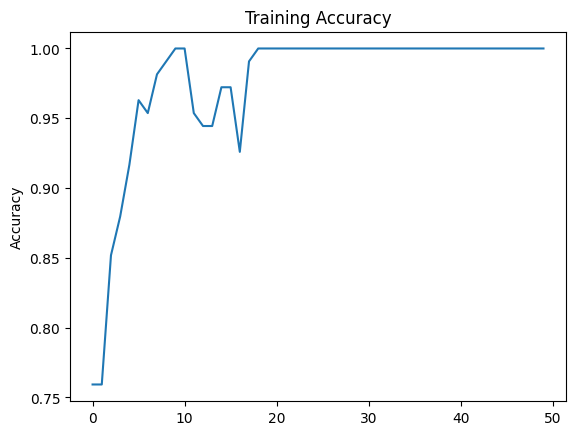

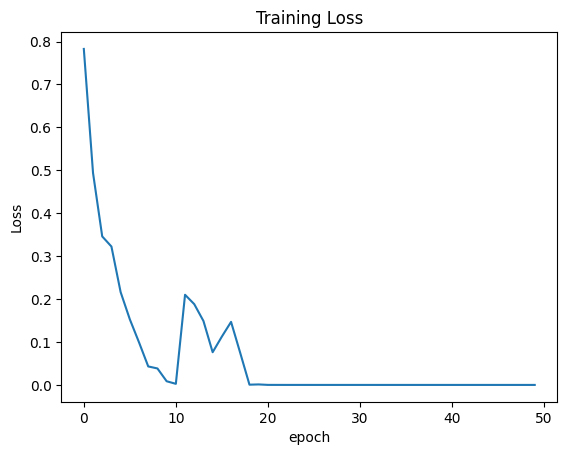

In [32]:
acc = history.history['accuracy']
loss = history.history['loss']

plt.figure()
plt.plot(acc, label='Training Accuracy')
plt.ylabel('Accuracy')
plt.title('Training Accuracy')

plt.figure()

plt.plot(loss, label='Training Loss')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.xlabel('epoch')
plt.show()

## Testando o novo Modelo

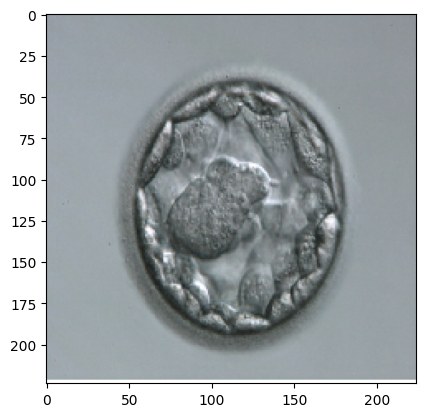

In [44]:
# Embrião 3AB 1.200
image_test_1 = tf.keras.preprocessing.image.load_img(r'/content/3AB 1.200.PNG', target_size=(224,224))
plt.imshow(image_test_1);

In [45]:
image_test_1 = tf.keras.preprocessing.image.img_to_array(image_test_1)
image_test_1 = np.expand_dims(image_test_1, axis = 0)
image_test_1 = tf.keras.applications.resnet50.preprocess_input(image_test_1)

predictions_1 = model.predict(image_test_1)
AA = float(predictions_1[0][0])
CB = float(predictions_1[0][1])
print(f" {100 * AA:.2f}% AA\n {100 * CB:.2f}% CB.")

1/1 [==============================] - 0s 23ms/step
 100.00% AA
 0.00% CB.


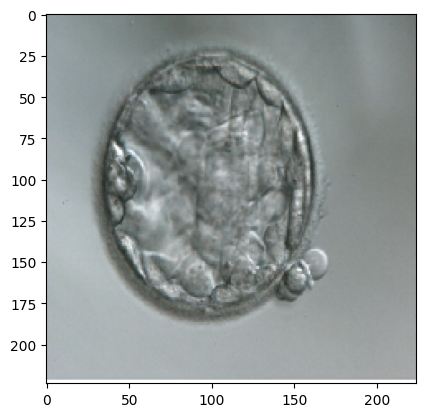

In [46]:
# Embrião 3BA 1.200
image_test_2 = tf.keras.preprocessing.image.load_img(r'/content/3BA 1.200.PNG', target_size=(224,224))
plt.imshow(image_test_2);

In [47]:
image_test_2 = tf.keras.preprocessing.image.img_to_array(image_test_2)
image_test_2 = np.expand_dims(image_test_2, axis = 0)
image_test_2 = tf.keras.applications.resnet50.preprocess_input(image_test_2)

predictions_2 = model.predict(image_test_2)
AA = float(predictions_2[0][0])
CB = float(predictions_2[0][1])
print(f" {100 * AA:.2f}% AA\n {100 * CB:.2f}% CB.")

1/1 [==============================] - 0s 23ms/step
 100.00% AA
 0.00% CB.


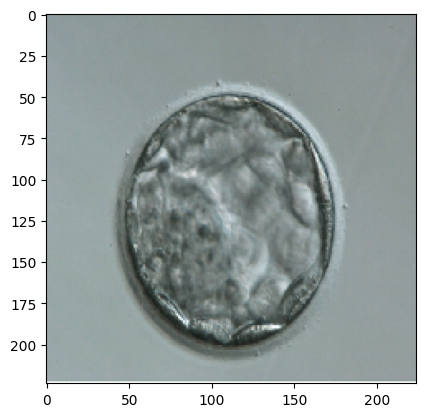

In [48]:
# Embrião 3BB 1.200
image_test_3 = tf.keras.preprocessing.image.load_img(r'/content/3BB 1.200.PNG', target_size=(224,224))
plt.imshow(image_test_3);

In [49]:
image_test_3 = tf.keras.preprocessing.image.img_to_array(image_test_3)
image_test_3 = np.expand_dims(image_test_3, axis = 0)
image_test_3 = tf.keras.applications.resnet50.preprocess_input(image_test_3)

predictions_3 = model.predict(image_test_3)
AA = float(predictions_3[0][0])
CB = float(predictions_3[0][1])
print(f" {100 * AA:.2f}% AA\n {100 * CB:.2f}% CB.")

1/1 [==============================] - 0s 23ms/step
 99.99% AA
 0.01% CB.


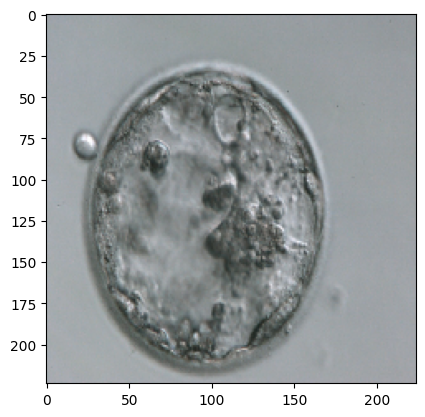

In [51]:
# Embrião 3BC 1.300
image_test_4 = tf.keras.preprocessing.image.load_img(r'/content/3BC 1.300.PNG', target_size=(224,224))
plt.imshow(image_test_4);

In [52]:
image_test_4 = tf.keras.preprocessing.image.img_to_array(image_test_4)
image_test_4 = np.expand_dims(image_test_4, axis = 0)
image_test_4 = tf.keras.applications.resnet50.preprocess_input(image_test_4)

predictions_4 = model.predict(image_test_4)
AA = float(predictions_4[0][0])
CB = float(predictions_4[0][1])
print(f" {100 * AA:.2f}% AA\n {100 * CB:.2f}% CB.")

1/1 [==============================] - 0s 22ms/step
 0.00% AA
 100.00% CB.


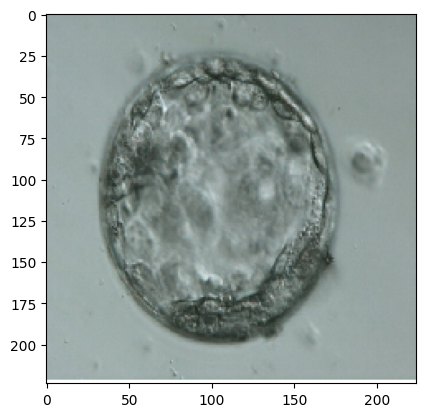

In [53]:
# Embrião 4CA 1.200
image_test_5 = tf.keras.preprocessing.image.load_img(r'/content/4CA 1.200.PNG', target_size=(224,224))
plt.imshow(image_test_5);

In [54]:
image_test_5 = tf.keras.preprocessing.image.img_to_array(image_test_5)
image_test_5 = np.expand_dims(image_test_5, axis = 0)
image_test_5 = tf.keras.applications.resnet50.preprocess_input(image_test_5)

predictions_5 = model.predict(image_test_5)
AA = float(predictions_5[0][0])
CB = float(predictions_5[0][1])
print(f" {100 * AA:.2f}% AA\n {100 * CB:.2f}% CB.")

1/1 [==============================] - 0s 23ms/step
 100.00% AA
 0.00% CB.


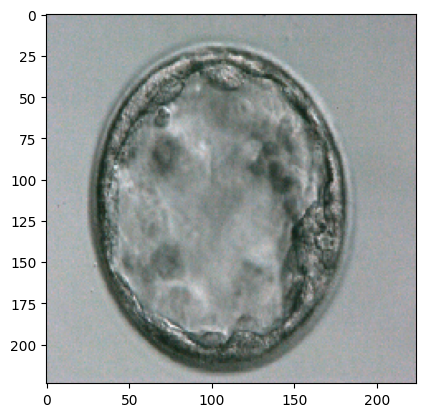

In [55]:
# Embrião 3CB 1.300
image_test_6 = tf.keras.preprocessing.image.load_img(r'/content/3CB 1.300.PNG', target_size=(224,224))
plt.imshow(image_test_6);

In [56]:
image_test_6 = tf.keras.preprocessing.image.img_to_array(image_test_6)
image_test_6 = np.expand_dims(image_test_6, axis = 0)
image_test_6 = tf.keras.applications.resnet50.preprocess_input(image_test_6)

predictions_6 = model.predict(image_test_6)
AA = float(predictions_6[0][0])
CB = float(predictions_6[0][1])
print(f" {100 * AA:.2f}% AA\n {100 * CB:.2f}% CB.")

1/1 [==============================] - 0s 25ms/step
 0.00% AA
 100.00% CB.


## Em Resumo...

Imagem 3AB 1.200:

*   100.00% AA
*   0.00% CB

Imagem 3BA 1.200:

*   100.00% AA
*   0.00% CB

Imagem 3BB 1.200:

*   99.99% AA
*   0.01% CB

Imagem 3BC 1.300:

*   0.00% AA
*   100.00% CB

Imagem 4CA 1.200:

*   100.00% AA
*   0.00% CB

Imagem 3CB 1.300:

*   0.00% AA
*   100.00% CB